# Quant Trading Strategies Final Project



In [1]:
import pandas as pd
import numpy as np
import requests 
import datetime as dt
import typing
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import time
import quandl
import nasdaqdatalink as ndl
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
apikey = 'J_fXGeVW_zC6RaDeJSQv'
quandl.ApiConfig.api_key = apikey

In [2]:
trade_transactions = pd.read_csv('C:/Users/dcste/OneDrive/Economics_Research/Economics_Research/trade_transactions.csv').drop(columns=['Unnamed: 15','Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19'])
trade_transactions = trade_transactions[trade_transactions.type != 'Exchange']

In [3]:
trade_transactions.type.unique()

array([nan, 'Purchase', 'Sale (Partial)', 'Sale (Full)'], dtype=object)

In [4]:
def filter_trade_type(trade_type:str):
    if trade_type == 'Purchase':
        trade_type = 'Buy'
    elif trade_type == 'Sale (Partial)':
        trade_type = 'Sell'
    elif trade_type == 'Sale (Full)':
        trade_type = 'Sell'
    return trade_type

In [5]:
trade_transactions['type'] = trade_transactions['type'].apply(filter_trade_type)

In [6]:
trade_transactions1  = trade_transactions[(trade_transactions.type == 'Buy')|(trade_transactions.type == 'Sell')]

In [7]:
trade_transactions['type'] = trade_transactions['type'].apply(filter_trade_type)
trade_transactions1 = trade_transactions1.dropna()

In [8]:
trade_transactions.type.unique()

array([nan, 'Buy', 'Sell'], dtype=object)

In [9]:
trade_transactions1['transaction_date'] = pd.to_datetime(trade_transactions1['transaction_date'])
trade_transactions1['disclosure_date'] = pd.to_datetime(trade_transactions1['disclosure_date'])

In [10]:
trade_transactions1

,transaction_date,disclosure_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,party,state,industry,sector
1,2023-01-23,2023-02-14,Joint,GOLD,Barrick Gold Corporation Common Stock (BC),Stock,Buy,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
2,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock <div class=...,Stock Option,Sell,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
3,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock <div class=...,Stock Option,Sell,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
4,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock,Stock,Buy,"$100,001 - $250,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
5,2023-01-13,2023-02-14,Joint,UAA,"Under Armour, Inc. Class A Common Stock",Stock,Buy,"$15,001 - $50,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Apparel,Consumer Non-Durables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,2015-01-16,2015-01-21,Self,NOG,"Northern Oil and Gas, Inc. (AMEX)",Stock,Buy,"$15,001 - $50,000",--,John Hoeven,https://efdsearch.senate.gov/search/view/ptr/1...,Republican,ND,Oil & Gas Production,Energy
7439,2015-01-06,2015-01-20,Self,FCX,Freeport-McMoRan Inc. (NYSE),Stock,Sell,"$50,001 - $100,000",--,John Hoeven,https://efdsearch.senate.gov/search/view/ptr/6...,Republican,ND,Precious Metals,Basic Industries
7451,2014-12-12,2015-01-05,Spouse,XOM,Exxon Mobil Corporation (NYSE),Stock,Sell,"$1,001 - $15,000",Sep,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,Republican,KS,Integrated oil Companies,Energy
7452,2014-12-19,2015-01-05,Spouse,BA,The Boeing Company (NYSE),Stock,Buy,"$1,001 - $15,000",R,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,Republican,KS,Aerospace,Capital Goods


In [11]:
tickers = list(trade_transactions1.ticker.unique())

In [12]:
tickers

['GOLD',
 'CLF',
 'UAA',
 'V',
 'KO',
 'AAPL',
 'TXN',
 'X',
 'PXD',
 'JPM',
 'CVS',
 'BMY',
 'BKNG',
 'ZTS',
 'AMZN',
 'ALGN',
 'RIO',
 'MGM',
 'AMT',
 'ATKR',
 'HOLX',
 'BHP',
 'RMD',
 'DLR',
 'AXS',
 'CME',
 'BSM',
 'EQNR',
 'MCD',
 'RNWK',
 'NU',
 'DIS',
 'PG',
 'KMB',
 'PYPL',
 'CLX',
 'QCOM',
 'C',
 'FWONK',
 'LSXMK',
 'LBRDK',
 'SYK',
 'META',
 'MDT',
 'MLM',
 'FFIV',
 'ELAN',
 'CMCSA',
 'BAX',
 'GOOG',
 'ADBE',
 'RPM',
 'NVDA',
 'MSFT',
 'TJX',
 'TMO',
 'LRCX',
 'TSM',
 'INTC',
 'F',
 'ATVI',
 'WIW',
 'LDP',
 'BATRK',
 'LBRDA',
 'BATRA',
 'XOM',
 'CVX',
 'VCTR',
 'VRTX',
 'SCI',
 'RELX',
 'RH',
 'PHM',
 'GIS',
 'GLPI',
 'EXR',
 'ETSY',
 'ELS',
 'DQ',
 'CROX',
 'CSCO',
 'AMGN',
 'WIT',
 'SEIC',
 'TROW',
 'NOC',
 'MNST',
 'MASI',
 'MKTX',
 'IDXX',
 'HON',
 'GGG',
 'IT',
 'GRMN',
 'FAST',
 'EL',
 'CHD',
 'AMAT',
 'APD',
 'MRO',
 'OXY',
 'FDX',
 'VZ',
 'MPW',
 'ABT',
 'HQL',
 'NID',
 'FIVE',
 'WFC',
 'VTRS',
 'ORCL',
 'TSCO',
 'SSYS',
 'GWW',
 'COST',
 'LMT',
 'CAT',
 'SBNY',
 'MMM

# Getting Tickers

In [13]:
start_date = '2014-12-12'
end_date = '2023-02-14'

In [14]:
price_df = pd.DataFrame(data = None)
for tick in tickers:
    temp = ndl.get_table('QUOTEMEDIA/PRICES', ticker = tick, api_key = apikey,\
        date = {'gte':start_date,'lte':end_date})
    price_df = pd.concat([price_df,temp], axis = 0)

In [15]:
price_df

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,GOLD,2023-02-14,17.81,17.88,17.4625,17.81,19493634.0,0.0,1.0,17.810000,17.880000,17.462500,17.810000,19493634.0
1,GOLD,2023-02-13,17.74,17.98,17.7100,17.93,9488266.0,0.0,1.0,17.740000,17.980000,17.710000,17.930000,9488266.0
2,GOLD,2023-02-10,17.79,18.05,17.6900,17.93,12456873.0,0.0,1.0,17.790000,18.050000,17.690000,17.930000,12456873.0
3,GOLD,2023-02-09,18.54,18.64,17.6100,17.81,17800792.0,0.0,1.0,18.540000,18.640000,17.610000,17.810000,17800792.0
4,GOLD,2023-02-08,18.54,18.56,18.1100,18.34,11934553.0,0.0,1.0,18.540000,18.560000,18.110000,18.340000,11934553.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,NOG,2014-12-18,6.35,6.45,5.7500,5.96,2989921.0,0.0,1.0,61.126691,62.089316,55.350941,57.372453,298992.1
2053,NOG,2014-12-17,5.26,6.24,5.2200,5.99,4070352.0,0.0,1.0,50.634078,60.067803,50.249028,57.661241,407035.2
2054,NOG,2014-12-16,4.95,5.71,4.7900,5.28,4430626.0,0.0,1.0,47.649940,54.965891,46.109740,50.826603,443062.6


In [16]:
price_df = price_df[['ticker', 'date','adj_open','adj_high','adj_low','adj_close','adj_volume']]

In [17]:
# Save to CSV
PRICES = price_df.to_csv('project_price_df.csv')

In [18]:
price_df

,ticker,date,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,
0,GOLD,2023-02-14,17.810000,17.880000,17.462500,17.810000,19493634.0
1,GOLD,2023-02-13,17.740000,17.980000,17.710000,17.930000,9488266.0
2,GOLD,2023-02-10,17.790000,18.050000,17.690000,17.930000,12456873.0
3,GOLD,2023-02-09,18.540000,18.640000,17.610000,17.810000,17800792.0
4,GOLD,2023-02-08,18.540000,18.560000,18.110000,18.340000,11934553.0
...,...,...,...,...,...,...,...
2052,NOG,2014-12-18,61.126691,62.089316,55.350941,57.372453,298992.1
2053,NOG,2014-12-17,50.634078,60.067803,50.249028,57.661241,407035.2
2054,NOG,2014-12-16,47.649940,54.965891,46.109740,50.826603,443062.6


In [19]:
msft = (price_df[price_df.ticker == 'MSFT']).set_index('date').sort_index()
nog = (price_df[price_df.ticker == 'NOG']).set_index('date').sort_index()

In [20]:
msft

,ticker,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,
2014-12-12,MSFT,40.863321,41.693166,40.767234,41.011820,34248371.0
2014-12-15,MSFT,41.230200,41.640755,40.662411,40.767234,29247761.0
2014-12-16,MSFT,40.094623,40.478972,39.422011,39.448217,47801392.0
2014-12-17,MSFT,39.352130,40.133931,39.221101,39.954859,34970865.0
2014-12-18,MSFT,40.688617,41.509727,40.477749,41.509727,40105550.0
...,...,...,...,...,...,...
2023-02-08,MSFT,272.511941,276.062975,265.539545,266.058236,54251280.0
2023-02-09,MSFT,273.110430,273.289976,262.138133,262.956068,39677594.0
2023-02-10,MSFT,260.871332,263.424884,260.005518,262.437378,25305259.0


# Creating Chaikin Money Flow Oscillator Function

In [21]:
def calculate_money_flow_volume_series(df:pd.DataFrame):
    '''
    Calculating Money Flow Series
    '''
    mfv = df['adj_volume']*(2*df['adj_close']-df['adj_high']-df['adj_low']/ \
        df['adj_high']- df['adj_low'])
    return mfv

def calculate_money_flow_volume(df:pd.DataFrame, n:int = 20):
    '''
    Calculates Money Flow Volume


    '''
    return calculate_money_flow_volume_series(df).rolling(n).sum()

def calculate_chaikin_money_flow(df:pd.DataFrame, n:int = 20):
    '''
    Calculates Chaikin Money Flow
    '''
    return calculate_money_flow_volume(df,n)/df['adj_volume'].rolling(n).sum()

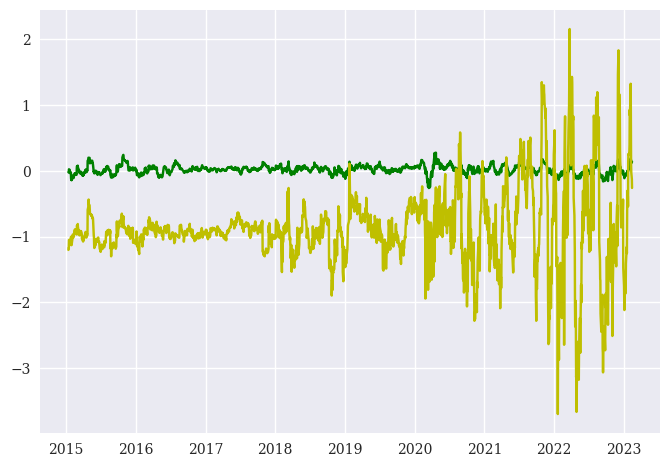

In [22]:
plt.plot(figsize = (10,8))

plt.plot(msft.adj_close.pct_change(21), label = 'MSFT Adjusted Close Price', c = 'g')
plt.plot(calculate_chaikin_money_flow(msft,21), label = 'Chaikin Money Flow', c = 'y')

<AxesSubplot:xlabel='date'>

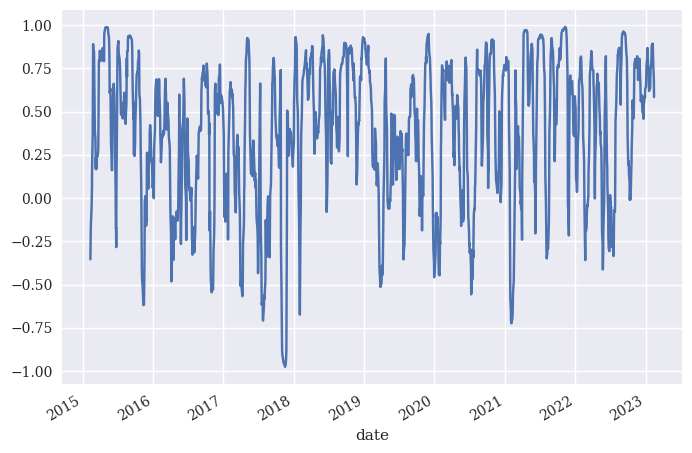

In [23]:
msft['adj_close'].rolling(21).corr(calculate_chaikin_money_flow(msft,21)).plot()

NameError: name 'CMH_df' is not defined

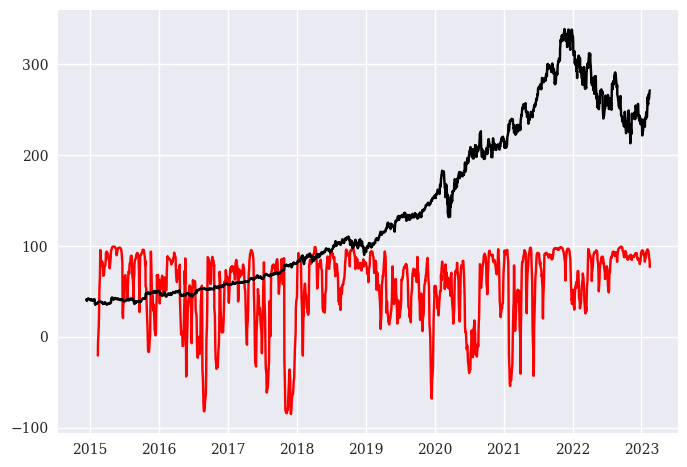

In [24]:
plt.plot(figsize = (10,8))
plt.plot(100*msft['adj_close'].pct_change(21).rolling(21).corr(calculate_chaikin_money_flow(msft,21)),label = 'CMF Correlation With MSFT RETURNS', c = 'r')
plt.plot(msft['adj_close'], label = 'MSFT Adjusted Closing Prices', c = 'black')
plt.axhline(CMH_df.CMH_Corr.mean(), c = 'b', label = 'Mean Correlation Between MSFT Returns and CMH')
plt.legend(loc = 0)

In [ ]:
CMH_df = pd.DataFrame(100*msft['adj_close'].pct_change().rolling(1).corr(calculate_chaikin_money_flow(msft,1)), columns=['CMH_Corr']).dropna()
CMH_df = CMH_df.merge(msft[['adj_close']], right_index=True,left_index=True)

In [ ]:
calculate_chaikin_money_flow(msft,100).mean()

-0.9076081441598153

In [ ]:
msft['adj_close'].pct_change().rolling(100).corr(calculate_chaikin_money_flow(msft,100)).mean()

0.12479574357756801

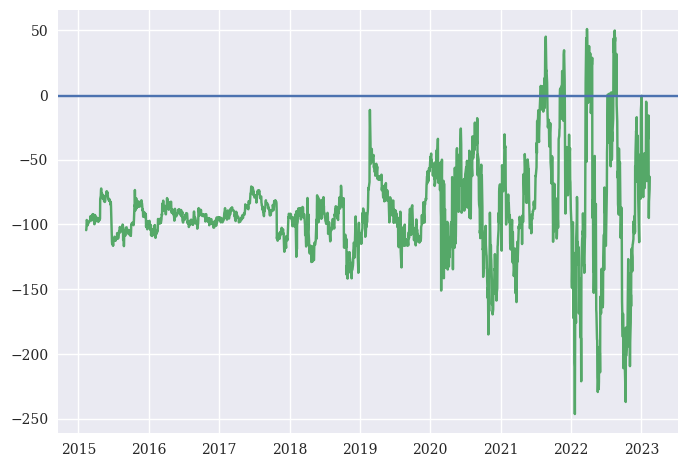

In [ ]:
plt.plot(figsize = (10,8))
plt.plot(CMH_df.CMH_Corr)

plt.plot(calculate_chaikin_money_flow(msft,40)*100)
plt.axhline(calculate_chaikin_money_flow(msft,1).mean())
plt.plot(CMH_df.adj_close)

<AxesSubplot:xlabel='date'>

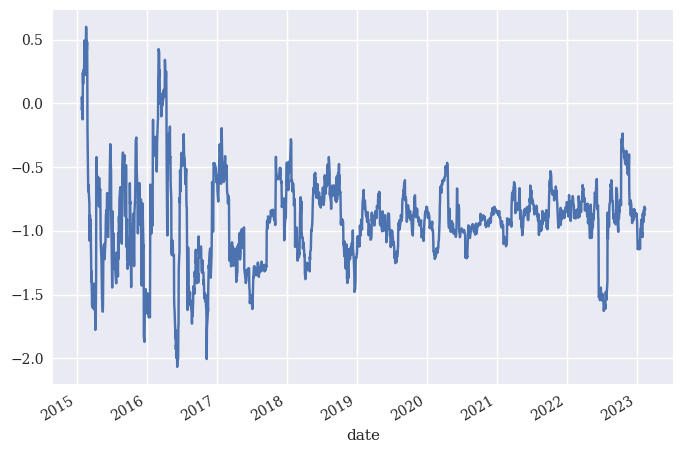

In [ ]:
calculate_chaikin_money_flow(nog,30).plot()

<AxesSubplot:xlabel='date'>

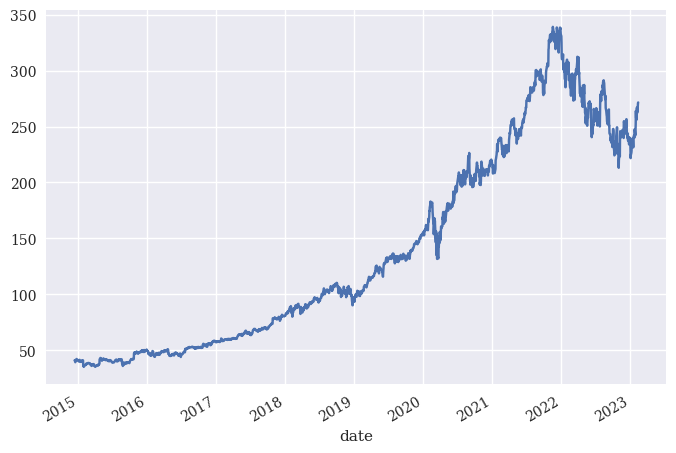

In [ ]:
msft['adj_close'].plot()

# Getting Quandl Data


SPY Earnings Yield: MULTPL/SP500_EARNINGS_YIELD_MONTH
Corporate Bond Yield (BAA Rated): FED/RIMLPBAAR_N_B
Corporate_Bond Yield: FED/RIMLPAAAR_N_B
yield_curve data: YC/USA

In [38]:
period_begin = '2004-01-01'

In [74]:
market = quandl.get_table('QUOTEMEDIA/PRICES', ticker = 'SPY',qopts = {'columns' : ['adj_close','date']}, date = {'gte':period_begin,'lte':end_date}).set_index('date').sort_index()
corporate_bond_yields = quandl.get(['FED/RIMLPBAAR_N_B', 'FED/RIMLPAAAR_N_B'], start_date = period_begin, end_date = end_date)*(1/100)
corporate_bond_yields.columns = ['BAA_Yield','AAA_Yield']
interest_rates = quandl.get('YC/USA', start_date = period_begin,end_date = end_date)[['1-Month','3-Month','10-Year']]*(1/100)
spy_earnings_yield = quandl.get('MULTPL/SP500_EARNINGS_YIELD_MONTH', start_date = period_begin, end_date = end_date).rename(columns={'Value':'MKT_EPS'})

In [69]:
m = market.resample('M').last()

In [80]:
trade_transactions1

,transaction_date,disclosure_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,party,state,industry,sector
1,2023-01-23,2023-02-14,Joint,GOLD,Barrick Gold Corporation Common Stock (BC),Stock,Buy,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
2,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock <div class=...,Stock Option,Sell,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
3,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock <div class=...,Stock Option,Sell,"$1,001 - $15,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
4,2023-01-18,2023-02-14,Joint,CLF,Cleveland-Cliffs Inc. Common Stock,Stock,Buy,"$100,001 - $250,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Precious Metals,Basic Industries
5,2023-01-13,2023-02-14,Joint,UAA,"Under Armour, Inc. Class A Common Stock",Stock,Buy,"$15,001 - $50,000",--,Tommy Tuberville,https://efdsearch.senate.gov/search/view/ptr/9...,Republican,AL,Apparel,Consumer Non-Durables
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,2015-01-16,2015-01-21,Self,NOG,"Northern Oil and Gas, Inc. (AMEX)",Stock,Buy,"$15,001 - $50,000",--,John Hoeven,https://efdsearch.senate.gov/search/view/ptr/1...,Republican,ND,Oil & Gas Production,Energy
7439,2015-01-06,2015-01-20,Self,FCX,Freeport-McMoRan Inc. (NYSE),Stock,Sell,"$50,001 - $100,000",--,John Hoeven,https://efdsearch.senate.gov/search/view/ptr/6...,Republican,ND,Precious Metals,Basic Industries
7451,2014-12-12,2015-01-05,Spouse,XOM,Exxon Mobil Corporation (NYSE),Stock,Sell,"$1,001 - $15,000",Sep,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,Republican,KS,Integrated oil Companies,Energy
7452,2014-12-19,2015-01-05,Spouse,BA,The Boeing Company (NYSE),Stock,Buy,"$1,001 - $15,000",R,Pat Roberts,https://efdsearch.senate.gov/search/view/ptr/f...,Republican,KS,Aerospace,Capital Goods
